Iteration 0, Difference = 2.450000
Iteration 500, Difference = 0.282107
Iteration 1000, Difference = 0.126835
Iteration 1500, Difference = 0.068827
Iteration 2000, Difference = 0.039824
Iteration 2500, Difference = 0.023605
Iteration 3000, Difference = 0.014099
Iteration 3500, Difference = 0.008432
Iteration 4000, Difference = 0.005037
Iteration 4500, Difference = 0.003005


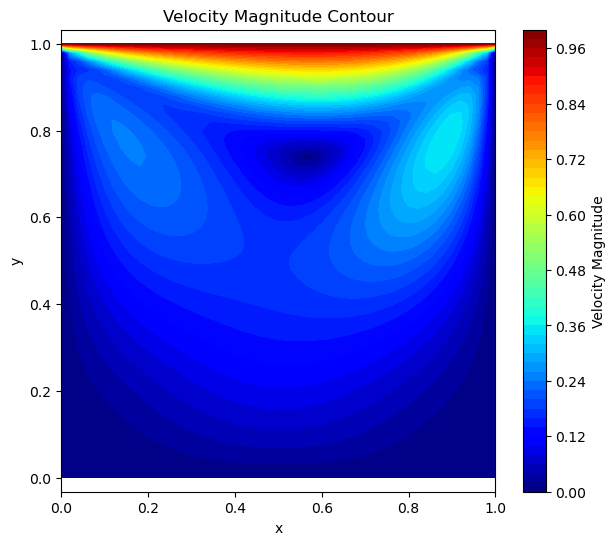

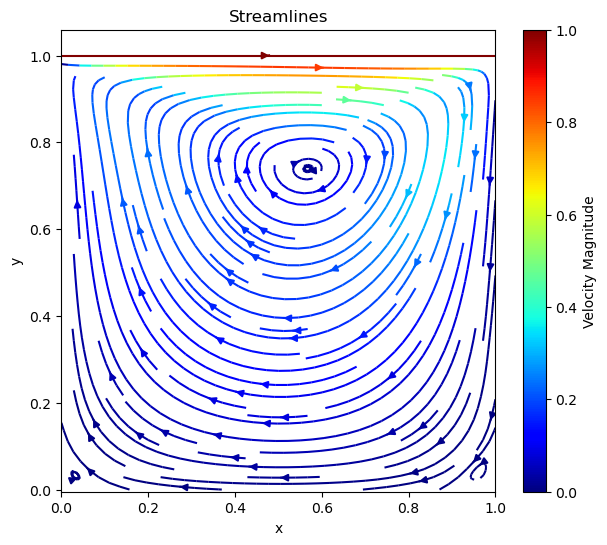

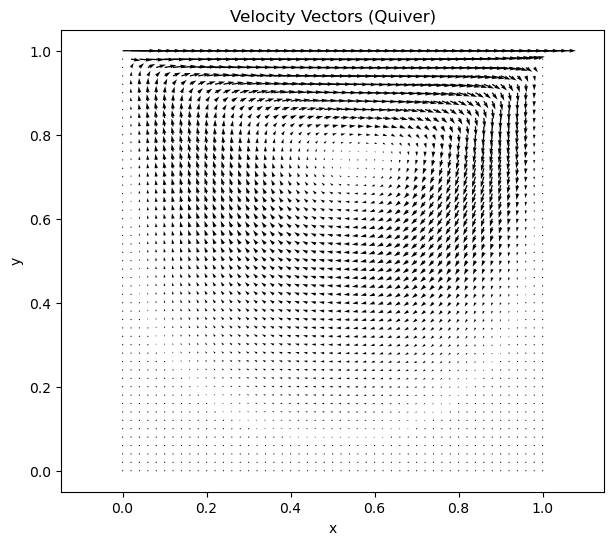

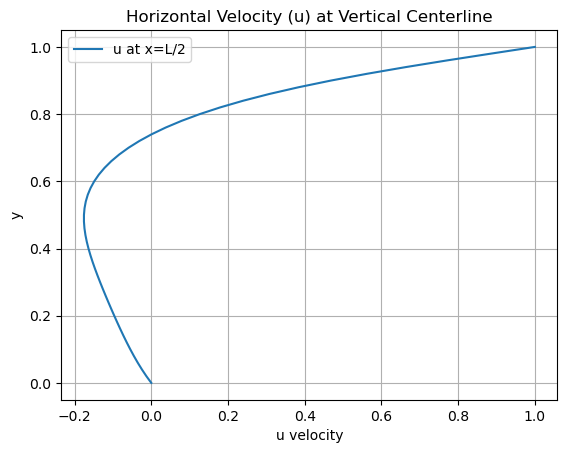

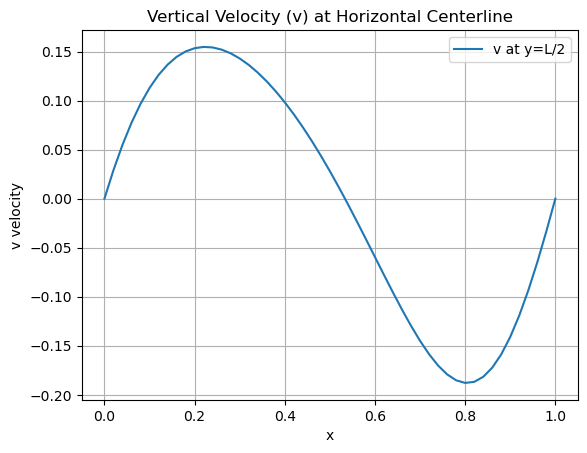

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Domain and grid
nx, ny = 51, 51
lx, ly = 1.0, 1.0
dx = lx / (nx - 1)
dy = ly / (ny - 1)

# Physical properties
Re = 50
rho = 1.0
nu = 1.0 / Re
dt = 0.001
nt = 5000
tol = 1e-5

# Field initialization
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

# Boundary condition: lid
u[-1, :] = 1.0

def build_rhs(b, u, v, dx, dy, dt, rho):
    b[1:-1, 1:-1] = rho * (1 / dt * (
        (u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx) +
        (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy)) -
        ((u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx))**2 -
        2 * ((u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dy) *
             (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dx)) -
        ((v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy))**2)
    return b

def pressure_poisson(p, b, dx, dy):
    pn = np.empty_like(p)
    for _ in range(50):
        pn = p.copy()
        p[1:-1, 1:-1] = (
            (pn[1:-1, 2:] + pn[1:-1, :-2]) * dy**2 +
            (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dx**2 -
            b[1:-1, 1:-1] * dx**2 * dy**2) / (2 * (dx**2 + dy**2))

        # Boundary conditions
        p[:, 0] = p[:, 1]
        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]
        p[-1, :] = 0
    return p

# Time stepping
for n in range(nt):
    un = u.copy()
    vn = v.copy()

    b = build_rhs(b, un, vn, dx, dy, dt, rho)
    p = pressure_poisson(p, b, dx, dy)

    # u-velocity
    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
        un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, :-2]) -
        vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[:-2, 1:-1]) -
        dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, :-2]) +
        nu * dt * (
            (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) / dx**2 +
            (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1]) / dy**2))

    # v-velocity
    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
        un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, :-2]) -
        vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[:-2, 1:-1]) -
        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[:-2, 1:-1]) +
        nu * dt * (
            (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]) / dx**2 +
            (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1]) / dy**2))

    # Boundary conditions
    u[0, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0
    u[-1, :] = 1  # Lid-driven
    v[0, :] = 0
    v[-1, :] = 0
    v[:, 0] = 0
    v[:, -1] = 0

    # Check convergence every 500 steps
    if n % 500 == 0:
        diff = np.sum(np.abs(u - un)) + np.sum(np.abs(v - vn))
        print(f"Iteration {n}, Difference = {diff:.6f}")
        if diff < tol:
            print("Converged.")
            break

# Create meshgrid
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
X, Y = np.meshgrid(x, y)
velocity_mag = np.sqrt(u**2 + v**2)

# --- 🟦 Plots ---

# Velocity magnitude contour
plt.figure(figsize=(7, 6))
plt.contourf(X, Y, velocity_mag, 50, cmap='jet')
plt.colorbar(label='Velocity Magnitude')
plt.title('Velocity Magnitude Contour')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Streamlines
plt.figure(figsize=(7, 6))
plt.streamplot(X, Y, u, v, density=1.2, color=velocity_mag, cmap='jet')
plt.colorbar(label='Velocity Magnitude')
plt.title('Streamlines')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Velocity Vectors (Quiver)
plt.figure(figsize=(7, 6))
plt.quiver(X, Y, u, v)
plt.title('Velocity Vectors (Quiver)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# u-velocity along vertical centerline
plt.figure()
plt.plot(u[:, nx // 2], y, label='u at x=L/2')
plt.xlabel('u velocity')
plt.ylabel('y')
plt.title('Horizontal Velocity (u) at Vertical Centerline')
plt.grid()
plt.legend()

# v-velocity along horizontal centerline
plt.figure()
plt.plot(x, v[ny // 2, :], label='v at y=L/2')
plt.xlabel('x')
plt.ylabel('v velocity')
plt.title('Vertical Velocity (v) at Horizontal Centerline')
plt.grid()
plt.legend()

plt.show()

